In [1]:
from PIL import Image, ImageDraw
from fuzzywuzzy import fuzz
import re
import sys

C:\Users\ansnz\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [2]:
def ocr_output_parser(doc_name):
    doc = open(doc_name, 'r')
    lines = doc.readlines()
    doc.close()
    result = []
    for line in lines:
        box = {}
        line = line.split(',')
        box['p1'] = (int(line[0]), int(line[1]))
        box['p2'] = (int(line[2]), int(line[3]))
        box['p3'] = (int(line[4]), int(line[5]))
        box['p4'] = (int(line[6]), int(line[7]))
        box['text'] = ','.join(line[8:]).replace('\n','')
        result.append(box)
    return result

54


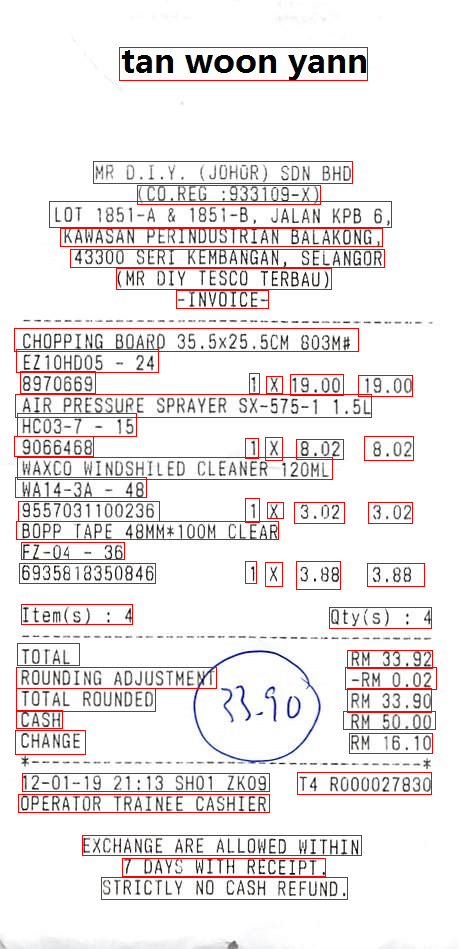

In [3]:
def draw_box(draw, box, width, height, color):
    draw.rectangle([box['p1'][0], box['p1'][1], box['p3'][0], box['p3'][1]], outline = color) 

def show_boxes(im, boxes, draw_pairs=False):
    draw = ImageDraw.Draw(im)
    width, height = im.size  

    for box in boxes:
        draw_box(draw, box, width, height, 'red')
            
    return im

im = Image.open('../receipt1.jpg', 'r')
boxes = ocr_output_parser('../OCR1.txt')
print(len(boxes))

show_boxes(im, boxes)

In [4]:
from ast import Index


def get_by_regex(boxes, regex, full_match=False):
    """
    Functions that finds all the boxes that match a regular expression, and return them with its matched text in a list
    """
    result = []
    for box in boxes:
        text = box['text']
        if full_match:
            match = re.fullmatch(regex, text)
        else:
            match = re.match(regex, text)

        if match:
            result.append((box, match[0]))
    return result

def get_highness(item):
    return item['p1'][1]

def get_by_vertival_position(boxes, index):
    """
    Function that return a box based on its vertical position
    """
    boxes = sorted(boxes, key = get_highness)
    try:
        return boxes[index], boxes[index]['text']
    except(IndexError):
        return None, ''

def get_score(item):
    """
    Function used to sort different list based on a score, getting the second element on an item
    """
    return abs(item[1])

def get_by_similarity(boxes, search, min_similarity):
    """
    Function that finds every box that has a min_similarity to a given search text, and returns them into a list, sorted by its similarity
    """
    result = [(box, fuzz.ratio(box['text'], search)) for box in boxes if fuzz.ratio(box['text'], search) > min_similarity]
    return sorted(result, key=get_score)

def get_by_down_direction(boxes, box, number):
    """
    Function that returns the next <number> boxes below a given box, the boxes list should be sorted by vertical position
    """
    if boxes.index(box) + 1 < len(boxes):
        return boxes[boxes.index(box)+1: boxes.index(box)+1+number]
    elif boxes.index(box) + 1 + number < len(boxes):
        return boxes[boxes.index(box)+1:]
    else:
        return []

def get_by_right_direction(boxes, box):
    """
    Function that finds all the boxes that are on the right side of a given box, and returns them into a list sorted by its 
    vertical alignment similarity to a given box
    """
    height = box['p3'][1] - box['p1'][1]
    li = box['p1'][1] - height
    ls = box['p3'][1] + height

    result = []
    for box1 in boxes:
        if box1['p1'][1] > li and box1['p1'][1] < ls and box != box1:
            vertical_dist = box['p1'][1] - box1['p1'][1]
            result.append((box1, vertical_dist))
    
    return sorted(result, key=get_score)

In [5]:
def extract_data(boxes):
    receipt = {
        'company': '',
        'date': '',
        'address': '',
        'line_items': [],
        'total': ''
    }

    #extracting date by regex
    try:
        date_box, date_text = get_by_regex(boxes, '[0-9]{2}[-]{1}[0-9]{2}[-]{1}[0-9]{2}')[0]
    except(IndexError):
        date_box, date_text = None, ''

    #extracting data based on its positioin at the receipt header
    company_box, company_text = get_by_vertival_position(boxes, 1)
    address = ' '.join([get_by_vertival_position(boxes, i)[1] for i in range(3,7)])

    #extracting products, starting by the '-INVOICE-' box and ending by the 'ITEM(S) : ' box
    try:
        invoice_box, invoice_score = get_by_similarity(boxes, '-INVOICE-', 90)[0]
    except:
        invoice_box, invoice_score = None, ''
    
    try:
        stop_box, stop_score = get_by_similarity(boxes, 'ITEM(S) : ', 80)[0]
    except(IndexError):
        stop_box, stop_score = None, ''

    #getting product boxes, assuming that each product will have 7 boxes
    search = True
    products = []
    while search:
        products.append(get_by_down_direction(boxes, invoice_box, 7))
        invoice_box = products[-1][-1]
        search = not stop_box in products[-1]
    products.pop()

    #parsing product lines by regular expressions
    for product in products:
        try:
            id_box, id_text = get_by_regex(product, '[0-9]{7,13}')[0]
            product.remove(id_box)
        except(IndexError):
            id_box, id_text = None, ''

        try:
            quantily_box, quantily_text = get_by_regex(product, '[0-9]+', full_match=True)[0]
        except(IndexError):
            quantily_box, quantily_text = None, ''
        
        try:
            price1_box, price1_text = get_by_regex(product, '[0-9]+[.]{1}[0-9]{2}')[0]
        except(IndexError):
            price1_box, price1_text = None, ''

        try:
            price2_box, price2_text = get_by_regex(product, '[0-9]+[.]{1}[0-9]{2}')[1]
        except(IndexError):
            price2_box, price2_text = None, ''
        
        if price1_text <= price2_text:
            unit_price = price1_text
            total_price = price2_text
        else:
            unit_price = price2_text
            total_price = price1_text

        receipt['line_items'].append({
            'sku': id_text,
            'quantily': quantily_text,
            'price': unit_price,
            'total': total_price
        })
    
    #extracting total rounded valor by getting the field box and searching to the right box
    try:
        total_rouded_box, total_rounded_text = get_by_similarity(boxes, 'TOTAL ROUNDED', 95)[0]
    except(IndexError):
        total_rouded_box, total_rounded_text = None, ''
    
    try:
        total_box_text = get_by_right_direction(boxes, total_rouded_box)[0][0]['text']
        total_text = re.search('[0-9]+[.]{1}[0-9]{1}[0]{1}', total_box_text)[0]
    except(IndexError):
        total_box_text = ''
        total_text = ''
    
    receipt['date'] = date_text
    receipt['company'] = company_text
    receipt['address'] = address
    receipt['total'] = total_text

    return receipt

In [6]:
def main():
    im = ['../receipt1.jpg', '../receipt2.jpg']
    boxes = [ocr_output_parser('../OCR1.txt'), ocr_output_parser('../OCR1.txt')]

    for i in range(len(im)):
        print(im[i],extract_data(boxes[i]))

In [7]:
main()

../receipt1.jpg {'company': 'MR D.T.Y. (JOHOR) SDN BHD', 'date': '12-01-19', 'address': 'LOT 1851-A & 1851-B, JALAN KPB 6, KAWASAN PERINDUSTRIAN BALAKONG, 43300 SERI KEMBANGAN, SELANGOR (MR DIY TESCO TERBAU)', 'line_items': [{'sku': '8970669', 'quantily': '1', 'price': '19.00', 'total': '19.00'}, {'sku': '9066468', 'quantily': '1', 'price': '8.02', 'total': '8.02'}, {'sku': '9557031100236', 'quantily': '1', 'price': '3.02', 'total': '3.02'}, {'sku': '6935818350846', 'quantily': '1', 'price': '3.88', 'total': '3.88'}], 'total': '33.90'}
../receipt2.jpg {'company': 'MR D.T.Y. (JOHOR) SDN BHD', 'date': '12-01-19', 'address': 'LOT 1851-A & 1851-B, JALAN KPB 6, KAWASAN PERINDUSTRIAN BALAKONG, 43300 SERI KEMBANGAN, SELANGOR (MR DIY TESCO TERBAU)', 'line_items': [{'sku': '8970669', 'quantily': '1', 'price': '19.00', 'total': '19.00'}, {'sku': '9066468', 'quantily': '1', 'price': '8.02', 'total': '8.02'}, {'sku': '9557031100236', 'quantily': '1', 'price': '3.02', 'total': '3.02'}, {'sku': '693